In [2]:
from pafpy import PafFile
from tqdm.notebook import tqdm
from collections import defaultdict
import intervaltree as itree
from Bio import SeqIO
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from collections import defaultdict
import time
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams.update({'font.size': 18})
import math, re

In [3]:
from glob import glob
# from hurry.filesize import size
import psutil
import shlex
import csv
from pathlib import Path
import itertools
import random
from collections import namedtuple
from dataclasses import dataclass, field

In [5]:
Minimap2Params = namedtuple("Minimap2Params", "is_ont n")
MashMap3Params = namedtuple("MashMap3Params", "L k ss pi n")
MashMap2Params = namedtuple("MashMap2Params", "L k w pi n")
MashMapParams = namedtuple("MashMapParams", "L k ss pi n tool")
ParameterSet = namedtuple("ParameterSet", "dataset mashmap2_params mashmap3_params minimap2_params")
Dataset = namedtuple("Dataset", "name reference queries")

@dataclass
class RunProfile:
    time: int = 0
    memory: int = 0

In [4]:
ss_to_dens_5000 = {10: 0.0027033015587942942,
 20: 0.004999545524382726,
 30: 0.007225297850085516,
 40: 0.009414666280896978,
 50: 0.011580825266216262,
 60: 0.0137304687797538,
 70: 0.015867562596763904,
 75: 0.0169,
 80: 0.017994721638507495,
 90: 0.020113733315396117,
 100: 0.022225882956137456,
 110: 0.024332211034229525,
 120: 0.026433437214099118,
 130: 0.028530192910771867,
 140: 0.03062297923626709,
 150: 0.032712196059314504,
 160: 0.03479819307413521,
 170: 0.03688125618779697,
 180: 0.038961631636590104,
 190: 0.04103953307815283,
 200: 0.04310220928250878,
 300: 0.06375817159996389,
 400: 0.08429124072361874,
 500: 0.10474345862936014,
 600: 0.12513590112065218,
 700: 0.14548170418253295,
 800: 0.16578947227428895,
 900: 0.18606471061147348,
 1000: 0.206311821699839}
ss_to_w = {ss: int(np.round(2/dens)) - 1 for (ss, dens) in ss_to_dens_5000.items()}

# ss_to_w[300] = 30
# ss_to_w[400] = 23
# ss_to_w[500] = 20

In [93]:
(1 - (5000-200+1) * (5000-200) / (5000*(5000+1))) * 3.2e9

250855428.91421717

In [89]:
pprint(ss_to_w)

{10: 739,
 20: 399,
 30: 276,
 40: 211,
 50: 172,
 60: 145,
 70: 125,
 75: 117,
 80: 110,
 90: 98,
 100: 89,
 110: 81,
 120: 75,
 130: 69,
 140: 64,
 150: 60,
 160: 56,
 170: 53,
 180: 50,
 190: 48,
 200: 45,
 300: 30,
 400: 23,
 500: 18,
 600: 15,
 700: 13,
 800: 11,
 900: 10,
 1000: 9}


In [11]:
empty_fasta = "/home/Users/blk6/Data/reads/empty.fa"
human_assemblies = list(glob("/home/Users/blk6/Data/assemblies/human/GCA_*.fa"))
human_assembly_HG02257 = "/home/Users/blk6/Data/assemblies/human/GCA_018466835.1.fa"
human_ref = "/home/Users/blk6/Data/assemblies/human/T2T_v2.1.fna"
HiFi_reads = "/home/Users/blk6/Data/reads/human/HiFi-5000-d2.fa"
ONT_reads = {ANI: f"/home/Users/blk6/Data/reads/human/ONT-{ANI}-nosd-d.5-5000.fa" for ANI in [99, 98, 95]}
ONT_indel_balanced_reads = {ANI: f"/home/Users/blk6/Data/reads/human/ONT-{ANI}-nosd-balanced-d2-5000.fa" for ANI in [99, 98, 95]}
yeast_pangenome = "/home/Users/blk6/Contribute/wfmash/ref-genomes/cerevisiae.pan.fa"
# chm13_mapquik = "/home/Users/blk6/Contribute/mapquik/experiments/nearperfect-chm13.10X.24kb.fa"
# maize_mapquik = "/home/Users/blk6/Contribute/mapquik/experiments/simulated-maize.30X.fa"
# maize_reference = "/home/Users/blk6/Data/assemblies/maize/ref/GCF_000005005.2_B73_RefGen_v4_genomic.fna"


# mapquik_chm13_run = [(human_ref, [chm13_mapquik], "mapquik-chm13")]
# mapquik_maize_run = [(maize_reference, [maize_mapquik], "mapquik-maize")]

empty_dataset = Dataset("empty-dataset", human_ref, (empty_fasta,))
chm13_hifi_dataset = Dataset("chm13-HiFi-reads", human_ref, (HiFi_reads,))
chm13_ONT_datasets = {ANI: Dataset(f"chm13-ONT-{ANI}-reads", human_ref, (ONT_reads[ANI],)) for ANI in ONT_reads}
chm13_ONT_indel_balanced_datasets = {ANI: Dataset(f"chm13-ONT-indel-balanced-{ANI}-reads", human_ref, (ONT_indel_balanced_reads[ANI],)) for ANI in ONT_reads}
chm13_HG02257_dataset = Dataset("chm13-HG02257", human_ref, (human_assembly_HG02257,))
yeast_pangenome_dataset = Dataset("yeast-pangenome", yeast_pangenome, [])

In [6]:
dataset_run_profile = defaultdict(        # Dataset name
    lambda: defaultdict(                  # Tool ParamsObj
        lambda: {                         
            "map": RunProfile(), 
            "align": RunProfile()
        }
    )
)

In [18]:
toolnames = [
    # "mashmap2"]
    "mashmap3"]
runs = defaultdict(list)

# HiFi run
default_pi = 95
L = 5000
n = 1
# for dataset in [chm13_HG02257_dataset, chm13_hifi_dataset, yeast_pangenome_dataset]:
#     for k in [19, 31]:
#         for ss in range(10, 81, 10):
#             mm3_params = MashMap3Params(L, k, ss, pi, n)
#             runs[dataset].append(mm3_params)


sketch_sizes = [20, 50, 80, 100, 150, 200, 300, 400]
# sketch_sizes = [150]
kmers = [19]

for k in kmers:
    for ss in sketch_sizes:
        # for tool in toolnames:
        #     if "empty" in tool:
        #         mm3_params = MashMapParams(L, k, ss, default_pi, n, tool=tool)
        #         runs[empty_dataset].append(mm3_params)

        for ANI, dataset in chm13_ONT_indel_balanced_datasets.items():
            pi = ANI-5 # What should this be???
            for tool in toolnames:
                if "empty" in tool:
                    continue
                mm3_params = MashMapParams(L, k, ss, pi, n, tool=tool)
                runs[dataset].append(mm3_params)
                
                
# for ANI, dataset in chm13_ONT_indel_balanced_datasets.items():
#     mm3_params = MashMapParams(5000, 19, 150, 95, 1, tool="minimap2")
#     runs[dataset].append(mm3_params)            


# for k, ss, ANI in [(19, 200, 99), (19, 200, 98), (19, 200, 95)]:
#     dataset = chm13_ONT_datasets[ANI]
#     pi = ANI-5 # What should this be???
#     mm3_params = MashMapParams(L, k, ss, pi, n, tool="mashmap3-hgf-fs")
#     runs[dataset].append(mm3_params)
#     mm3_params = MashMapParams(L, k, ss, pi, n, tool="mashmap3")
#     runs[dataset].append(mm3_params)


In [15]:
print(len(runs), list(runs)[:10])

1 [Dataset(name='chm13-ONT-indel-balanced-95-reads', reference='/home/Users/blk6/Data/assemblies/human/T2T_v2.1.fna', queries=('/home/Users/blk6/Data/reads/human/ONT-95-nosd-balanced-d2-5000.fa',))]


In [16]:
CONCURRENT_RUNS = 1
THREADS = 16
run_name_to_fstream = defaultdict(lambda: defaultdict(dict))
active_runs = {}
with open("runtimes.txt", "w") as profile_out:
    profile_out.write(f"Run-basename\ttime")

for dataset, params_list in runs.items():
    for params in params_list:
        dataset_name = dataset.name
        ref = dataset.reference
        queries = dataset.queries
        run_base_name = f"{params.tool}-ss{params.ss}-k{params.k}-p{params.pi}-n{params.n}-L{params.L}"
        output_dir = f"/home/Users/blk6/Contribute/wfmash/benchmarking/{dataset_name}/{run_base_name}"
        Path(output_dir).mkdir(parents=True, exist_ok=True)
        if "mashmap3" in params.tool:
            index_file = Path(f"/home/Users/blk6/Contribute/wfmash/benchmarking/index-test/human-ss{params.ss}-k{params.k}-L{params.L}.index")
            # if save in tool:
            #     index_flag = f"--indexSave {index_file}"
            # elif "noload" in tool:
            #     index_flag = ""
            # else:
            #     assert(index_file.exists())
            #     index_flag = f"--indexLoad {index_file}"
            index_flag = ""
            cmd_args = f"""
                /usr/bin/time -v /home/Users/blk6/Contribute/MashMap/build-release/bin/mashmap
                --noMerge 
                --blockLength 1 
                {index_flag}
                -k {params.k} 
                --sketchSize {params.ss} 
                -t {THREADS} 
                -n {params.n} 
                --pi {params.pi} 
                -s {params.L} 
                -r {ref} 
                -q {' '.join(queries)} 
                """.replace("\n", " ")
            stdout_file = open(f"{output_dir}/{params.tool}.approx.paf", 'w')
        elif params.tool == "mashmap2":
            cmd_args = f"""
                /usr/bin/time -v /home/Users/blk6/Contribute/MashMap-orig/mashmap
                -k {params.k} 
                --window_size {math.ceil(ss_to_w[params.ss])} 
                -t {THREADS}
                --pi {params.pi} 
                -s {params.L} 
                -o {output_dir}/{params.tool}.approx.paf
                -r {ref} -q {' '.join(queries)}""".replace("\n", " ")
            stdout_file = open(f"{output_dir}/{params.tool}.out", 'w')
        elif params.tool == "minimap2":
            cmd_args = f"""
                /usr/bin/time -v minimap2
                {ref} {' '.join(queries)}
                -t {THREADS}
                -x map-ont""".replace("\n", " ")
            stdout_file = open(f"{output_dir}/{params.tool}.approx.paf", 'w')
        cmd_args = re.sub(' +', ' ', cmd_args)
        # print(cmd_args)
        run_name_to_fstream[run_base_name]["stdout"] = stdout_file
        stderr_file = open(f"{output_dir}/{params.tool}.err", 'w')
        run_name_to_fstream[run_base_name]["stderr"] = stderr_file
        print(f"Running {run_base_name}")
        active_runs[run_base_name] = (psutil.Popen(shlex.split(cmd_args), stdout=stdout_file, stderr=stderr_file), params.tool)
        time_tracker = 0
        while len(active_runs) >= CONCURRENT_RUNS:
            active_run_pairs = list(active_runs.items())
            for rbn, (p, st) in active_run_pairs:
                # t2 = None
                try:
                    if p.status() == "zombie":
                        raise psutil.NoSuchProcess(p.pid)
                    curtime = time.time()
                    if curtime > time_tracker + 5:
                        dataset_run_profile[dataset_name][run_base_name]["map"].memory = max(dataset_run_profile[dataset_name][run_base_name]["map"].memory, p.memory_info().rss)
                    t2 = p.cpu_times()
                    dataset_run_profile[dataset_name][run_base_name]["map"].time = t2.system + t2.user + t2.children_system + t2.children_user
                except psutil.NoSuchProcess as e:
                    with open("runtimes.txt", "a") as profile_out:
                        profile_out.write(f"{'EMPTY' if dataset_name == 'empty-dataset' else ''}-{rbn}\t{dataset_run_profile[dataset_name][run_base_name]['map'].time : .2f}\n")
                    print(f"Done {rbn}\t{dataset_run_profile[dataset_name][run_base_name]['map'].time : .2f}")
                    run_name_to_fstream[rbn]["stdout"].close()
                    run_name_to_fstream[rbn]["stderr"].close()
                    del run_name_to_fstream[rbn]
                    del active_runs[rbn]
            if curtime > time_tracker + 5:
                time_tracker = curtime

time_tracker = 0
while len(active_runs) > 0:
    active_run_pairs = list(active_runs.items())
    for rbn, (p, st) in active_run_pairs:
        t2 = None
        try:
            curtime = time.time()
            if curtime > time_tracker + 5:
                dataset_run_profile[dataset_name][run_base_name]["map"].memory = max(dataset_run_profile[dataset_name][run_base_name]["map"].memory, p.memory_info().rss)
            t2 = p.cpu_times()
            dataset_run_profile[dataset_name][run_base_name]["map"].time = t2.system + t2.user + t2.children_system + t2.children_user
            if p.status() == "zombie":
                raise psutil.NoSuchProcess(p.pid)
        except psutil.NoSuchProcess as e:
            with open("runtimes.txt", "a") as profile_out:
                profile_out.write(f"{'EMPTY' if dataset_name == 'empty-dataset' else ''}-{rbn}\t{dataset_run_profile[dataset_name][run_base_name]['map'].time : .2f}\n")
            print(f"Done {rbn}\t{dataset_run_profile[dataset_name][run_base_name]['map'].time : .2f}")
            run_name_to_fstream[rbn]["stdout"].close()
            run_name_to_fstream[rbn]["stderr"].close()
            del run_name_to_fstream[rbn]
            del active_runs[rbn]
    if curtime > time_tracker + 5:
        time_tracker = curtime
                        


Running mashmap2-ss20-k19-p90-n1-L5000
Done mashmap2-ss20-k19-p90-n1-L5000	 16478.58
Running mashmap2-ss50-k19-p90-n1-L5000
Done mashmap2-ss50-k19-p90-n1-L5000	 7634.37
Running mashmap2-ss80-k19-p90-n1-L5000
Done mashmap2-ss80-k19-p90-n1-L5000	 7882.92
Running mashmap2-ss100-k19-p90-n1-L5000
Done mashmap2-ss100-k19-p90-n1-L5000	 10179.88


In [27]:
t2

pcputimes(user=0.0, system=0.0, children_user=6634.55, children_system=607.81, iowait=0.0)

In [36]:
import csv
with open("run-profile-mashmap2.tsv", 'w') as profile_out:
    writer = csv.DictWriter(profile_out, delimiter='\t', fieldnames=["Name",  "L", "ss", "k", "pi", "map time (s)", "map memory (b)"])
    writer.writeheader()
    for dataset_name, param_dict in dataset_run_profile.items():
        for mm3_params, profile in param_dict.items():
            writer.writerow({
                "Name": dataset_name,
                "L": mm3_params.L,
                "ss": mm3_params.ss,
                "k": mm3_params.k,
                "pi": mm3_params.pi,
                "map time (s)": profile["map"].time,
                "map memory (b)": profile["map"].memory
            })

AttributeError: 'str' object has no attribute 'L'

In [ ]:
CONCURRENT_RUNS = 1
THREADS = 70
run_name_to_fstream = defaultdict(lambda: {tn: {} for tn in toolnames})
active_runs = {}

for run in runs:
    dataset_name = run.dataset.name
    ref = run.dataset.reference
    queries = run.dataset.queries
    mm3_params = run.mashmap3_params
    if run.mashmap3_params:
        params = run.mashmap3_params
        run_base_name = f"{dataset_name}-mashmap3-ss{params.ss}-k{params.k}-p{params.pi}-n{params.n}-L{params.L}"
        output_dir = f"/home/Users/blk6/Contribute/wfmash/benchmarking/{dataset_name}/{run_base_name}"
        Path(output_dir).mkdir(parents=True, exist_ok=True)
        cmd_args = f"/home/Users/blk6/Contribute/wfmash/build/bin/wfmash -t {THREADS} -n {params.n} -p {params.pi} -s {params.L} {ref} {' '.join(queries)} -i {output_dir}/{run_base_name}.paf"
        stdout_file = open(f"{output_dir}/{run_base_name}.align", 'w')
        run_name_to_fstream[run_base_name]["stdout"] = stdout_file
        stderr_file = open(f"{output_dir}/{run_base_name}.align.err", 'w')
        run_name_to_fstream[run_base_name]["stderr"] = stderr_file
        print(f"Running {run_base_name}")
        
        active_runs[run_base_name] = (psutil.Popen(shlex.split(cmd_args), stdout=stdout_file, stderr=stderr_file), "mashmap3")
        time_tracker = 0
        while len(active_runs) >= CONCURRENT_RUNS:
            active_run_pairs = list(active_runs.items())
            for rbn, (p, st) in active_run_pairs:
                t2 = None
                try:
                    if p.status() == "zombie":
                        raise psutil.NoSuchProcess(p.pid)
                    curtime = time.time()
                    if curtime > time_tracker + 5:
                        dataset_run_profile[dataset_name][run.mashmap3_params]["align"].memory = max(dataset_run_profile[dataset_name][run.mashmap3_params]["align"].memory, p.memory_info().rss)
                    t2 = p.cpu_times()
                    dataset_run_profile[dataset_name][run.mashmap3_params]['align'].time = t2.system + t2.user + t2.children_system + t2.children_user
                except psutil.NoSuchProcess as e:
                    print(f"Done {rbn}\t{dataset_run_profile[dataset_name][run.mashmap3_params]['align'].time : .2f}")
                    run_name_to_fstream[rbn]["stdout"].close()
                    run_name_to_fstream[rbn]["stderr"].close()
                    del run_name_to_fstream[rbn]
                    del active_runs[rbn]
            if curtime > time_tracker + 5:
                time_tracker = curtime
                        

time_tracker = 0
while len(active_runs) > 0:
    active_run_pairs = list(active_runs.items())
    for rbn, (p, st) in active_run_pairs:
        t2 = None
        try:
            curtime = time.time()
            if curtime > time_tracker + 5:
                dataset_run_profile[dataset_name][run.mashmap3_params]["align"].memory = max(dataset_run_profile[dataset_name][run.mashmap3_params]["align"].memory, p.memory_info().rss)
            t2 = p.cpu_times()
            dataset_run_profile[dataset_name][run.mashmap3_params]['align'].time = t2.system + t2.user + t2.children_system + t2.children_user
            if p.status() == "zombie":
                raise psutil.NoSuchProcess(p.pid)
        except psutil.NoSuchProcess as e:
            print(f"Done {rbn}\t{dataset_run_profile[dataset_name][run.mashmap3_params]['align'].time : .2f}")
            run_name_to_fstream[rbn]["stdout"].close()
            run_name_to_fstream[rbn]["stderr"].close()
            del run_name_to_fstream[rbn]
            del active_runs[rbn]
    if curtime > time_tracker + 5:
        time_tracker = curtime
                        


Running chm13-HG02257-mashmap3-ss10-k19-p95-n6-L5000
Done chm13-HG02257-mashmap3-ss10-k19-p95-n6-L5000	 17199.20
Running chm13-HG02257-mashmap3-ss20-k19-p95-n6-L5000
Done chm13-HG02257-mashmap3-ss20-k19-p95-n6-L5000	 16840.09
Running chm13-HG02257-mashmap3-ss30-k19-p95-n6-L5000
Done chm13-HG02257-mashmap3-ss30-k19-p95-n6-L5000	 16488.37
Running chm13-HG02257-mashmap3-ss40-k19-p95-n6-L5000
Done chm13-HG02257-mashmap3-ss40-k19-p95-n6-L5000	 16446.49
Running chm13-HG02257-mashmap3-ss50-k19-p95-n6-L5000
Done chm13-HG02257-mashmap3-ss50-k19-p95-n6-L5000	 16130.39
Running chm13-HG02257-mashmap3-ss60-k19-p95-n6-L5000
Done chm13-HG02257-mashmap3-ss60-k19-p95-n6-L5000	 16057.12
Running chm13-HG02257-mashmap3-ss70-k19-p95-n6-L5000
Done chm13-HG02257-mashmap3-ss70-k19-p95-n6-L5000	 16117.00
Running chm13-HG02257-mashmap3-ss80-k19-p95-n6-L5000
Done chm13-HG02257-mashmap3-ss80-k19-p95-n6-L5000	 16294.10
Running chm13-HG02257-mashmap3-ss10-k31-p95-n6-L5000
Done chm13-HG02257-mashmap3-ss10-k31-p95-n6

In [224]:
import pickle as pck
with open("map-times-nochain.pck", 'wb') as mapping_out:
    pck.dump(run_name_to_runtime, mapping_out)
with open("map-mems-nochain.pck", 'wb') as mapping_out:
    pck.dump(run_name_to_memprof, mapping_out)

dict_keys(['minmer-ss40-p95-n1-L5000', 'minmer-ss40-p90-n1-L5000', 'minmer-ss40-p85-n1-L5000', 'minmer-ss40-p80-n1-L5000', 'minmer-ss60-p95-n1-L5000', 'minmer-ss60-p90-n1-L5000', 'minmer-ss60-p85-n1-L5000', 'minmer-ss60-p80-n1-L5000', 'minmer-ss80-p95-n1-L5000', 'minmer-ss80-p90-n1-L5000', 'minmer-ss80-p85-n1-L5000', 'minmer-ss80-p80-n1-L5000', 'minmer-ss100-p95-n1-L5000', 'minmer-ss100-p90-n1-L5000', 'minmer-ss100-p85-n1-L5000', 'minmer-ss100-p80-n1-L5000'])


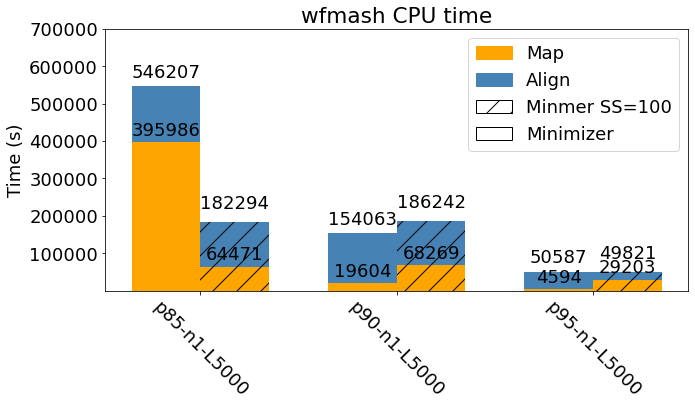

In [274]:
import matplotlib.patches as mpatches

SS=100
Ps = [85, 90, 95]
labels = [f"p{p}-n1-L5000" for p in Ps]
width = 0.35
x = np.arange(len(labels))
print(run_name_to_runtime["minmer"].keys())
minmer_map_times = [int(run_name_to_runtime["minmer"][f"minmer-ss{SS}-{label}"]) for label in labels]
minmer_align_times = [int(run_name_to_runtime_align["minmer"][f"minmer-ss{SS}-{label}"]) for label in labels]

minimizer_map_times = [int(run_name_to_runtime["minimizer"][f"minimizer-{label}"]) for label in labels]
minimizer_align_times = [int(run_name_to_runtime_align["minimizer"][f"minimizer-{label}"]) for label in labels]


fig, ax = plt.subplots()
map_patch = mpatches.Patch(color='orange', label='Map')
align_patch = mpatches.Patch(color='steelblue', label='Align')
minmer_patch = mpatches.Patch(facecolor="white", edgecolor="black", label=f'Minmer SS={SS}', hatch="/")
minimizer_patch = mpatches.Patch(facecolor="white", edgecolor="black", label=f'Minimizer')

rects1 = ax.bar(x + width/2, minmer_map_times, width, label="Map", color="orange", hatch='/')
rects2 = ax.bar(x + width/2, minmer_align_times, width, label='Align', bottom=minmer_map_times, color="steelblue",  hatch='/')
rects3 = ax.bar(x - width/2, minimizer_map_times, width, label="Map", color="orange")
rects4 = ax.bar(x - width/2, minimizer_align_times, width, label='Align', bottom=minimizer_map_times, color="steelblue")
# rects4

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time (s)')
ax.set_title('wfmash CPU time')
ax.set_xticks(x, labels, rotation=-45)
ax.set_ylim(1, 7e5)
ax.legend(handles=[map_patch, align_patch, minmer_patch, minimizer_patch])
# ax.set_yscale("log")

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=10)
ax.bar_label(rects3, padding=3)
ax.bar_label(rects4, padding=5)

fig.tight_layout()

plt.show()

In [283]:
minimizer_map_mems

[5, 5, 3, 2]

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (4,) and arg 3 with shape (3,).

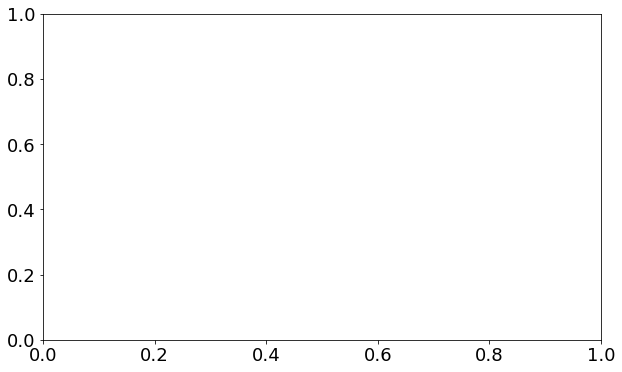

In [279]:
import matplotlib.patches as mpatches

SS=40
Ps = [80, 85, 90, 95]
labels = [f"p{p}-n1-L5000" for p in Ps]
width = 0.35
x = np.arange(len(labels))

minmer_map_mems = [int(max( z.rss/1000000000 for z in run_name_to_memprof["minmer"][f"minmer-ss{SS}-{label}"])) for label in labels]
minmer_align_mems = [int(max(z.rss/1000000000 for z in run_name_to_memprof_align["minmer"][f"minmer-ss{SS}-{label}"])) for label in labels]

minimizer_map_mems = [int(max(z.rss/1000000000 for z in run_name_to_memprof["minimizer"][f"minimizer-{label}"])) for label in labels]
minimizer_align_mems = [int(max(z.rss/1000000000 for z in run_name_to_memprof_align["minimizer"][f"minimizer-{label}"])) for label in labels]


fig, ax = plt.subplots()
map_patch = mpatches.Patch(color='orange', label='Map')
align_patch = mpatches.Patch(color='steelblue', label='Align')
minmer_patch = mpatches.Patch(facecolor="orange", edgecolor="black", label=f'Minmer SS={SS}', hatch="/")
minimizer_patch = mpatches.Patch(facecolor="orange", edgecolor="black", label=f'Minimizer')

# rects1 = ax.bar(x + width/2, minmer_map_mems, width, label="Map", color="orange", hatch='/')
rects2 = ax.bar(x + width/2, minmer_align_mems, width, label='Align', bottom=minmer_map_times, color="steelblue",  hatch='/')
# rects3 = ax.bar(x - width/2, minimizer_map_mems, width, label="Map", color="orange")
rects4 = ax.bar(x - width/2, minimizer_align_mems, width, label='Align', bottom=minimizer_map_times, color="steelblue")
# rects3 = ax.bar(x + width/2, women_means, width, label='Minimizer')
# rects4

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mem (Gb)')
ax.set_title('wfmash Peak RAM (mapping)')
ax.set_xticks(x, labels, rotation=-45)
ax.set_ylim(0, 350)
ax.legend(handles=[minmer_patch, minimizer_patch])
# ax.set_yscale("log")

ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)
# ax.bar_label(rects4, padding=3)

fig.tight_layout()

plt.show()

# Results analysis


In [ ]:
reference_f = SeqIO.index("/home/Users/blk6/Data/reads/human/T2T_v2.1.fna", "fasta")
query_index = SeqIO.index("/home/Users/blk6/Data/assemblies/human/GCA_018466835.1.fa", "fasta")


In [ ]:
rid_to_len = {rid: len(seq) for rid, seq in tqdm(query_index.items())}

  0%|          | 0/306 [00:00<?, ?it/s]

In [ ]:
minimizer_paf_file = "ref-to-HG-minimizer-p85-n3.align"
minmer_paf_file =    "ref-to-HG-minmer-ss70-p85-n3.align"

seed_types = ["minmer", "minimizer"]
paf_files = {"minmer": "ref-to-HG-minmer-ss70-p85-n3.align", "minimizer": "ref-to-HG-minimizer-p85-n3.align"}
IT_dicts = {"minmer": defaultdict(itree.IntervalTree), "minimizer": defaultdict(itree.IntervalTree)}

In [ ]:
for seed_type in seed_types:
    with PafFile(paf_files[seed_type]) as paf_reader:
        for record in tqdm(paf_reader):
            IT_dicts[seed_type][record.qname].addi(record.qstart, record.qend, record)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
coverage_dicts = {"minmer": defaultdict(float), "minimizer": defaultdict(float)}

for rid in tqdm(query_index):
    for seed_type in seed_types:
        rid_len = rid_to_len[rid]
        tree = IT_dicts[seed_type][rid]
        tree.merge_overlaps()
        covered_nucs = 0
        for (start, end, _) in tree:
            covered_nucs += end-start
        coverage_dicts[seed_type][rid] = covered_nucs / rid_len

    # print(f"{rid}:\t{coverage_dicts['minmer'][rid]/rid_len: .3f}\t{coverage_dicts['minimizer'][rid]/rid_len: .3f}")
    

  0%|          | 0/306 [00:00<?, ?it/s]

In [ ]:
def symlog_bins(arr, n_bins, zero_eps=0.1, padding=0):
    """
    Splits a data range into log-like bins but with 0 and negative values taken into account.
    Can be used together with matplotlib 'symlog' axis sacale (i.e. ax.set_xscale('symlog'))
    Feel free to contribute: https://gist.github.com/artoby/0bcf790cfebed5805fbbb6a9853fe5d5
    """
    a = min(arr) / (1 + padding)
    b = max(arr) * (1 + padding)
        
    if a > b:
        a, b = b, a
        
    neg_range_log = None
    if a < -zero_eps:
        neg_range_log = [np.log10(-a), np.log10(zero_eps)]
    
    # Add a value to zero bin edges in case a lies within [-zero_eps; zero_eps) - so an additional bin will be added before positive range
    zero_bin_edges = []
    if -zero_eps <= a < zero_eps:
        zero_bin_edges = [a]
            
    pos_range_log = None
    if b > zero_eps:
        pos_range_log = [np.log10(max(a, zero_eps)), np.log10(b)]

    nonzero_n_bin_edges = n_bins + 1 - len(zero_bin_edges)
    
    neg_range_log_size = (neg_range_log[0] - neg_range_log[1]) if neg_range_log is not None else 0
    pos_range_log_size = (pos_range_log[1] - pos_range_log[0]) if pos_range_log is not None else 0
    
    range_log_size = neg_range_log_size + pos_range_log_size
    pos_n_bin_edges_raw = int(round(nonzero_n_bin_edges * (pos_range_log_size/range_log_size))) if range_log_size > 0 else 0
    # Ensure each range has at least 2 edges if it's not empty
    neg_n_bin_edges = max(2, nonzero_n_bin_edges - pos_n_bin_edges_raw) if neg_range_log_size > 0 else 0
    pos_n_bin_edges = max(2, nonzero_n_bin_edges - neg_n_bin_edges) if pos_range_log_size > 0 else 0
    
    neg_bin_edges = []
    if neg_n_bin_edges > 0:
        neg_bin_edges = list(-np.logspace(neg_range_log[0], neg_range_log[1], neg_n_bin_edges))
        
    pos_bin_edges = []
    if pos_n_bin_edges > 0:
        pos_bin_edges = list(np.logspace(pos_range_log[0], pos_range_log[1], pos_n_bin_edges))
    
    result = neg_bin_edges + zero_bin_edges + pos_bin_edges
    return result

In [226]:
diffs = [rid_to_len[rid]*(coverage_dicts["minmer"][rid] - coverage_dicts["minimizer"][rid]) for rid in rid_to_len.keys()]
bins = symlog_bins(diffs, n_bins=100)
plt.hist(diffs, bins=bins)
plt.title("Difference in Minmer nuc. covered vs Minimizer nuc. covered")
plt.xscale("symlog")
plt.show()
print(stats.describe(diffs))

NameError: name 'rid_to_len' is not defined

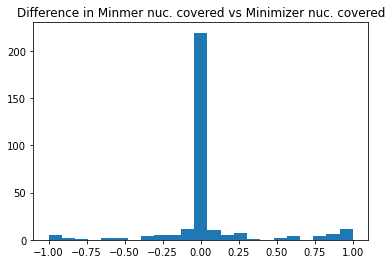

DescribeResult(nobs=306, minmax=(-1.0, 1.0), mean=0.038200096452483435, variance=0.09561901452837603, skewness=0.6911491340882462, kurtosis=4.6523172360747305)


In [ ]:
diffs = [(coverage_dicts["minmer"][rid] - coverage_dicts["minimizer"][rid]) for rid in rid_to_len.keys()]
# bins = symlog_bins(diffs, n_bins=100)
bins = list(np.linspace(min(diffs), max(diffs), 24))
plt.hist(diffs, bins=bins)
plt.title("Difference in Minmer nuc. covered vs Minimizer nuc. covered")
plt.show()
print(stats.describe(diffs))